In [1]:
# Get the imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from locscale.include.emmer.ndimage.profile_tools import compute_radial_profile, frequency_array
from locscale.include.emmer.ndimage.map_utils import load_map



In [2]:
emd_unsharpened_map_path = "/home/abharadwaj1/papers/elife_paper/figure_information/data/maps/emd_3061/model_free/processing_files/EMD_3061_unfiltered.mrc"
emd_pseudomodel_modmap_path = "/home/abharadwaj1/papers/elife_paper/figure_information/data/maps/emd_3061/model_free/processing_files/EMD_3061_unfiltered_confidenceMap_raw_gradient_pseudomodel_proper_element_composition_shifted_bfactors._4locscale.mrc"
emd_atomic_modmap_path = "/home/abharadwaj1/papers/elife_paper/figure_information/data/maps/emd_3061/model_based/processing_files/5a63_shifted_servalcat_refined_shifted_bfactors..m_4locscale.mrc"
emd_unsharpened_map, apix = load_map(emd_unsharpened_map_path)

rp_emd_unsharpened = compute_radial_profile(emd_unsharpened_map)
freq = frequency_array(rp_emd_unsharpened, apix)



NEW FUNCTION using Numpy FFT


In [25]:
# Script to demonstrate the process of creating deviated radial profile 
# Get pdb coordinate
def get_local_profile(emmap_path, pdb_path, chain_name, res_seqid, atom_name, wilson_cutoff,fsc_cutoff):
    import gemmi
    from locscale.include.emmer.ndimage.profile_tools import compute_radial_profile, frequency_array, estimate_bfactor_standard
    from locscale.include.emmer.ndimage.map_utils import convert_pdb_to_mrc_position, extract_window, load_map, resample_map

    st = gemmi.read_structure(pdb_path)
    emmap, apix = load_map(emmap_path)

    
    for res in st[0][chain_name]:
        if res.seqid.num == res_seqid:
            ca_atom_position = res.get_ca().pos.tolist()
            #print("Residue name: ",res.name)
    
    mrc_position = convert_pdb_to_mrc_position([ca_atom_position], apix)[0]
    window_size_pix = int(round(25/apix))
    emmap_wn = extract_window(emmap, mrc_position, size=window_size_pix)
    
    rp_emmap_wn = compute_radial_profile(emmap_wn)
    freq = frequency_array_custom(rp_emmap_wn, apix)
    
    bfactor, amp, qfit = estimate_bfactor_standard(freq, rp_emmap_wn, wilson_cutoff=wilson_cutoff, fsc_cutoff=fsc_cutoff,\
                                                     return_amplitude=True, return_fit_quality=True, standard_notation=True)
    exponential_fit = amp * np.exp(-0.25 * bfactor * freq**2)
    
    profiles = {
        'freq':freq,
        'rp':rp_emmap_wn,
        'exp':exponential_fit,
        'qfit':round(qfit,2),
        'bfactor':round(bfactor,2)
        }
    
    return profiles


In [4]:
from tqdm import tqdm
## Atom spec
chain_name_1 = "A"
res_seqid_1 = 612
atom_name_1 = "CA"

## Atom spec
chain_name_2 = "B"
res_seqid_2 = 380
atom_name_2 = "CA"

## Atom spec
chain_name_3 = "C"
res_seqid_3 = 249
atom_name_3 = "CA"
## Calculation begin

emmap_path = emd_unsharpened_map_path
pdb_path = "/home/abharadwaj1/papers/elife_paper/figure_information/data/maps/emd_3061/model_based/processing_files/5a63_shifted_servalcat_refined.pdb"
wilson_cutoff = 10
fsc_resolution = 3.4

# profiles_1 = get_local_profile(emmap_path, pdb_path, chain_name_1, res_seqid_1, atom_name_1, wilson_cutoff, fsc_resolution)    
# profiles_2 = get_local_profile(emmap_path, pdb_path, chain_name_2, res_seqid_2, atom_name_2, wilson_cutoff, fsc_resolution)    
# profiles_3 = get_local_profile(emmap_path, pdb_path, chain_name_3, res_seqid_3, atom_name_3, wilson_cutoff, fsc_resolution)    

# for each residue id get the bfactor 

# bfactor_per_residue = {}
# radial_profiles_residues = {}
# for residue_seqid in tqdm(range(1, 800)):
#     try:
#         profiles = get_local_profile(emd_atomic_modmap_path, pdb_path, chain_name_1, residue_seqid, atom_name_3, wilson_cutoff, fsc_resolution)
#         bfactor_per_residue[residue_seqid] = (profiles['bfactor'], profiles['qfit'])
#         radial_profiles_residues[residue_seqid] = profiles['rp']
#     except UnboundLocalError:
#         print("UnboundLocalError at residue: ", residue_seqid)
#         continue
    

        

In [5]:
# freq_temp = profiles['freq']
# for rp in radial_profiles_residues.values():
#     plt.plot(freq_temp**2, np.log(rp), color='grey', alpha=0.01)

In [6]:

# # sort the bfactor_per_residue dictionary by the bfactor value
# sorted_bfactor_per_residue = sorted(bfactor_per_residue.items(), key=lambda x: x[1])

# # get the five lowest bfactor residues
# lowest_bfactor_residues = sorted_bfactor_per_residue[:50]

# # print the residue ID with the five lowest bfactor and the bfactor value
# for residue_id, bfactor_qfit in lowest_bfactor_residues:
#     print(residue_id, bfactor_qfit, end = "|")




In [200]:

from plot_utils import pretty_plot_radial_profile

target_residue_id = 189                        
profiles_1 = get_local_profile(emd_atomic_modmap_path, pdb_path, chain_name_3, target_residue_id, atom_name_1, wilson_cutoff, fsc_resolution)    
profiles_2 = get_local_profile(emd_pseudomodel_modmap_path, pdb_path, chain_name_3, target_residue_id, atom_name_1, wilson_cutoff, fsc_resolution)

fig = pretty_plot_radial_profile(profiles_1['freq'], [profiles_1['rp'], profiles_2['rp']], figsize_cm=(8,8),
                                legends=["B-factor: {:.1f}".format(profiles_1['bfactor']), "B-factor: {:.1f}".format(profiles_2['bfactor'])],
                                plot_type="make_log", fontscale=1.2, linewidth=2, title="Residue ID: {}".format(target_residue_id))

figure_path = "/home/abharadwaj1/papers/elife_paper/figure_information/outputs/figure_2/emd_radial_profile.eps"
fig.savefig(figure_path, bbox_inches='tight')


NEW FUNCTION inside
NEW FUNCTION inside


/home/abharadwaj1/papers/elife_paper/locscale_v2_paper/scripts/jupyter_notebooks/plot_utils.py:588: RuntimeWarning: divide by zero encountered in double_scalars
  ax2.set_xticklabels([round(1/np.sqrt(x),1) for x in ax1.get_xticks()])
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [201]:
profiles_1['freq']

array([0.07936508, 0.11408731, 0.14880953, 0.18353175, 0.21825398,
       0.2529762 , 0.28769843, 0.32242065, 0.35714287])

In [202]:
from locscale.include.emmer.ndimage.profile_tools import scale_profiles, merge_two_profiles, \
        add_deviations_to_reference_profile, frequency_array, estimate_bfactor_standard, get_theoretical_profile
fsc_cutoff = 3.4
wilson_cutoff = 10
rp_atomic = profiles_1['rp']
rp_pseudo = profiles_2['rp']
ref_profile = rp_pseudo
theoretical_profile_tuple = get_theoretical_profile_custom(length=len(rp_pseudo),apix=apix, profile_type="sheet")
freq = theoretical_profile_tuple[0]

##########################################################################################
# Calculate the local wilson cutoff to apply deviations
##########################################################################################
num_atoms = ref_profile[0]
mol_weight = num_atoms * 16  # daltons 
wilson_cutoff_local = 1/(0.309 * np.power(mol_weight, -1/12))   ## From Amit Singer
wilson_cutoff_local = np.clip(wilson_cutoff_local, fsc_cutoff*1.5, wilson_cutoff)

##########################################################################################
# Scale the theoretical profile to match the bfactor of the reference profile
##########################################################################################
reference_profile_tuple = (freq, ref_profile)
scaled_theoretical_tuple,(bfactor,amp, qfit) = scale_profiles(reference_profile_tuple, theoretical_profile_tuple,
                                        wilson_cutoff=wilson_cutoff_local, fsc_cutoff=apix*2, \
                                        return_bfactor_properties=True)
bfactor = -1 * bfactor  ## Standard notation
scaled_theoretical_amplitude = scaled_theoretical_tuple[1]

smooth = 1.5

## Using merge_profile
scaled_reference_profile = merge_two_profiles(ref_profile,scaled_theoretical_amplitude,freq,smooth=smooth,d_cutoff=wilson_cutoff_local)

############################################################################################
## Apply the required deviations to the reference profile to match theoretical prediction
############################################################################################
deviations_begin = wilson_cutoff_local
deviations_end = fsc_cutoff
magnify = 1.5

deviated_reference_profile, exp_fit = add_deviations_to_reference_profile(
    freq, ref_profile, scaled_theoretical_amplitude, wilson_cutoff=wilson_cutoff_local, \
    nyquist_cutoff=apix*2, deviation_freq_start=deviations_begin, \
    deviation_freq_end=deviations_end, magnify=magnify)
        
reference_profile_for_scaling = deviated_reference_profile 


CUSTOM FUNCTION inside
[0.0078125  0.01170343]
freq_resampled[0:2] =  [0.         0.04464286]
Length of freq_resampled =  9


/home/abharadwaj1/dev/locscale/locscale/include/emmer/ndimage/profile_tools.py:150: RuntimeWarning: divide by zero encountered in true_divide
  d = 1 / freq


In [203]:
common_freq = np.linspace(0, 1/(apix*2), num=len(rp_pseudo), endpoint=True)
fig_combined = pretty_plot_radial_profile(common_freq, [reference_profile_for_scaling, rp_atomic, ref_profile], figsize_cm=(8,8),
                                legends=["Deviated profile", "Atomic", "Pseudo"],showlegend=True,
                                plot_type="make_log", fontscale=1.2, linewidth=1, markersize=10, font="Arial")

/home/abharadwaj1/papers/elife_paper/locscale_v2_paper/scripts/jupyter_notebooks/plot_utils.py:588: RuntimeWarning: invalid value encountered in sqrt
  ax2.set_xticklabels([round(1/np.sqrt(x),1) for x in ax1.get_xticks()])
/home/abharadwaj1/papers/elife_paper/locscale_v2_paper/scripts/jupyter_notebooks/plot_utils.py:588: RuntimeWarning: divide by zero encountered in double_scalars
  ax2.set_xticklabels([round(1/np.sqrt(x),1) for x in ax1.get_xticks()])


In [204]:
for i in range(len(freq)):
    print(freq[i], freq_rp[i], common_freq[i], round(1/common_freq[i], 2), round(1/freq_rp[i], 2), round(1/freq[i], 2))

0.0 0.07936508296929086 0.0 inf 12.6 inf
0.044642859170226104 0.1140873067683556 0.044642859170226104 22.4 8.77 22.4
0.08928571834045221 0.14880953056742036 0.08928571834045221 11.2 6.72 11.2
0.13392857751067833 0.1835317543664851 0.13392857751067833 7.47 5.45 7.47
0.17857143668090442 0.21825397816554987 0.17857143668090442 5.6 4.58 5.6
0.2232142958511305 0.2529762019646146 0.2232142958511305 4.48 3.95 4.48
0.26785715502135665 0.2876984257636793 0.26785715502135665 3.73 3.48 3.73
0.31250001419158274 0.3224206495627441 0.31250001419158274 3.2 3.1 3.2
0.35714287336180883 0.35714287336180883 0.35714287336180883 2.8 2.8 2.8


/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


In [205]:
freq[2]-freq[1]

0.044642859170226104

In [206]:

def frequency_array_custom(amplitudes=None,apix=None,profile_size=None):
    '''
    Returns a numpy array with elements corresponding to the frequencies of a signal

    Parameters
    ----------
    amplitudes : numpy.ndarray (1,N)
        Amplitudes 
    apix : float
        pixel size, or more generally the size in real units for each index (time, or space)

    Returns
    -------
    freq : numpy.ndarray (1,N)
        Frequencies corresponding to the amplitudes, given the pixelsize
        

    '''
    if amplitudes is not None:
        n = len(amplitudes)
    elif profile_size is not None:
        n = profile_size
    else:
        print("Please enter the size of the array or send the array itself!")
        return 0
    
    if apix is None:
        print("Warning: voxelsize parameter not entered. \n Using apix = 1")
        apix = 1
        
    #freq = np.linspace(1/(apix*n*2),1/(apix*2),n,endpoint=True)
    start_freq = (1/(apix*n))
    end_freq = 1/(apix*2)
    freq = np.linspace(start_freq,end_freq,n,endpoint=True)
    

    print("NEW FUNCTION inside")
    return freq


def get_theoretical_profile_custom(length,apix, profile_type='helix'):
    import pickle
    from locscale.include.emmer.ndimage.profile_tools import resample_1d, frequency_array
    from locscale.utils.file_tools import get_locscale_path
    import os
    
    path_to_locscale = get_locscale_path()
    location_of_theoretical_profiles = os.path.join(path_to_locscale, "locscale","utils","theoretical_profiles.pickle")
    
    with open(location_of_theoretical_profiles,'rb') as f:
        profiles = pickle.load(f)
    
    theoretical_profile = profiles[profile_type]
    freq_old = theoretical_profile['freq']
    print("CUSTOM FUNCTION inside")
    print(freq_old[0:2])
    freq_limits = (0, 1/(2*apix))
    resampled_theoretical_profile = resample_1d(freq_old, theoretical_profile['profile'],num=length, xlims=freq_limits)
    freq_resampled = resampled_theoretical_profile[0]
    print("freq_resampled[0:2] = ", freq_resampled[0:2])
    print("Length of freq_resampled = ", len(freq_resampled))
    return resampled_theoretical_profile

In [207]:
1/(apix*2)

0.35714287336180883

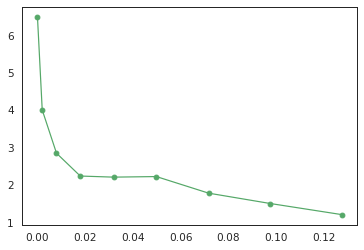

In [208]:
plt.plot(freq**2, np.log(scaled_theoretical_amplitude), "go-", label="Atomic")
#plt.plot(freq_rp**2, np.log(deviated_reference_profile), "ro-", label="Atomic")

In [209]:
apix

1.3999999364217122

In [210]:
1/freq[0]

/home/abharadwaj1/miniconda3/envs/locscale_dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


inf

In [217]:
figure_path_combined = "/home/abharadwaj1/papers/elife_paper/figure_information/outputs/figure_2/emd_3061_radial_profile_with_deviations.eps"
fig_combined.savefig(figure_path_combined, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [212]:
n = len(rp_pseudo)
freq = np.linspace(1/(apix*n*2),1/(apix*2),n,endpoint=True)
print(freq[0], freq[-1])

0.03968254148464543 0.35714287336180883


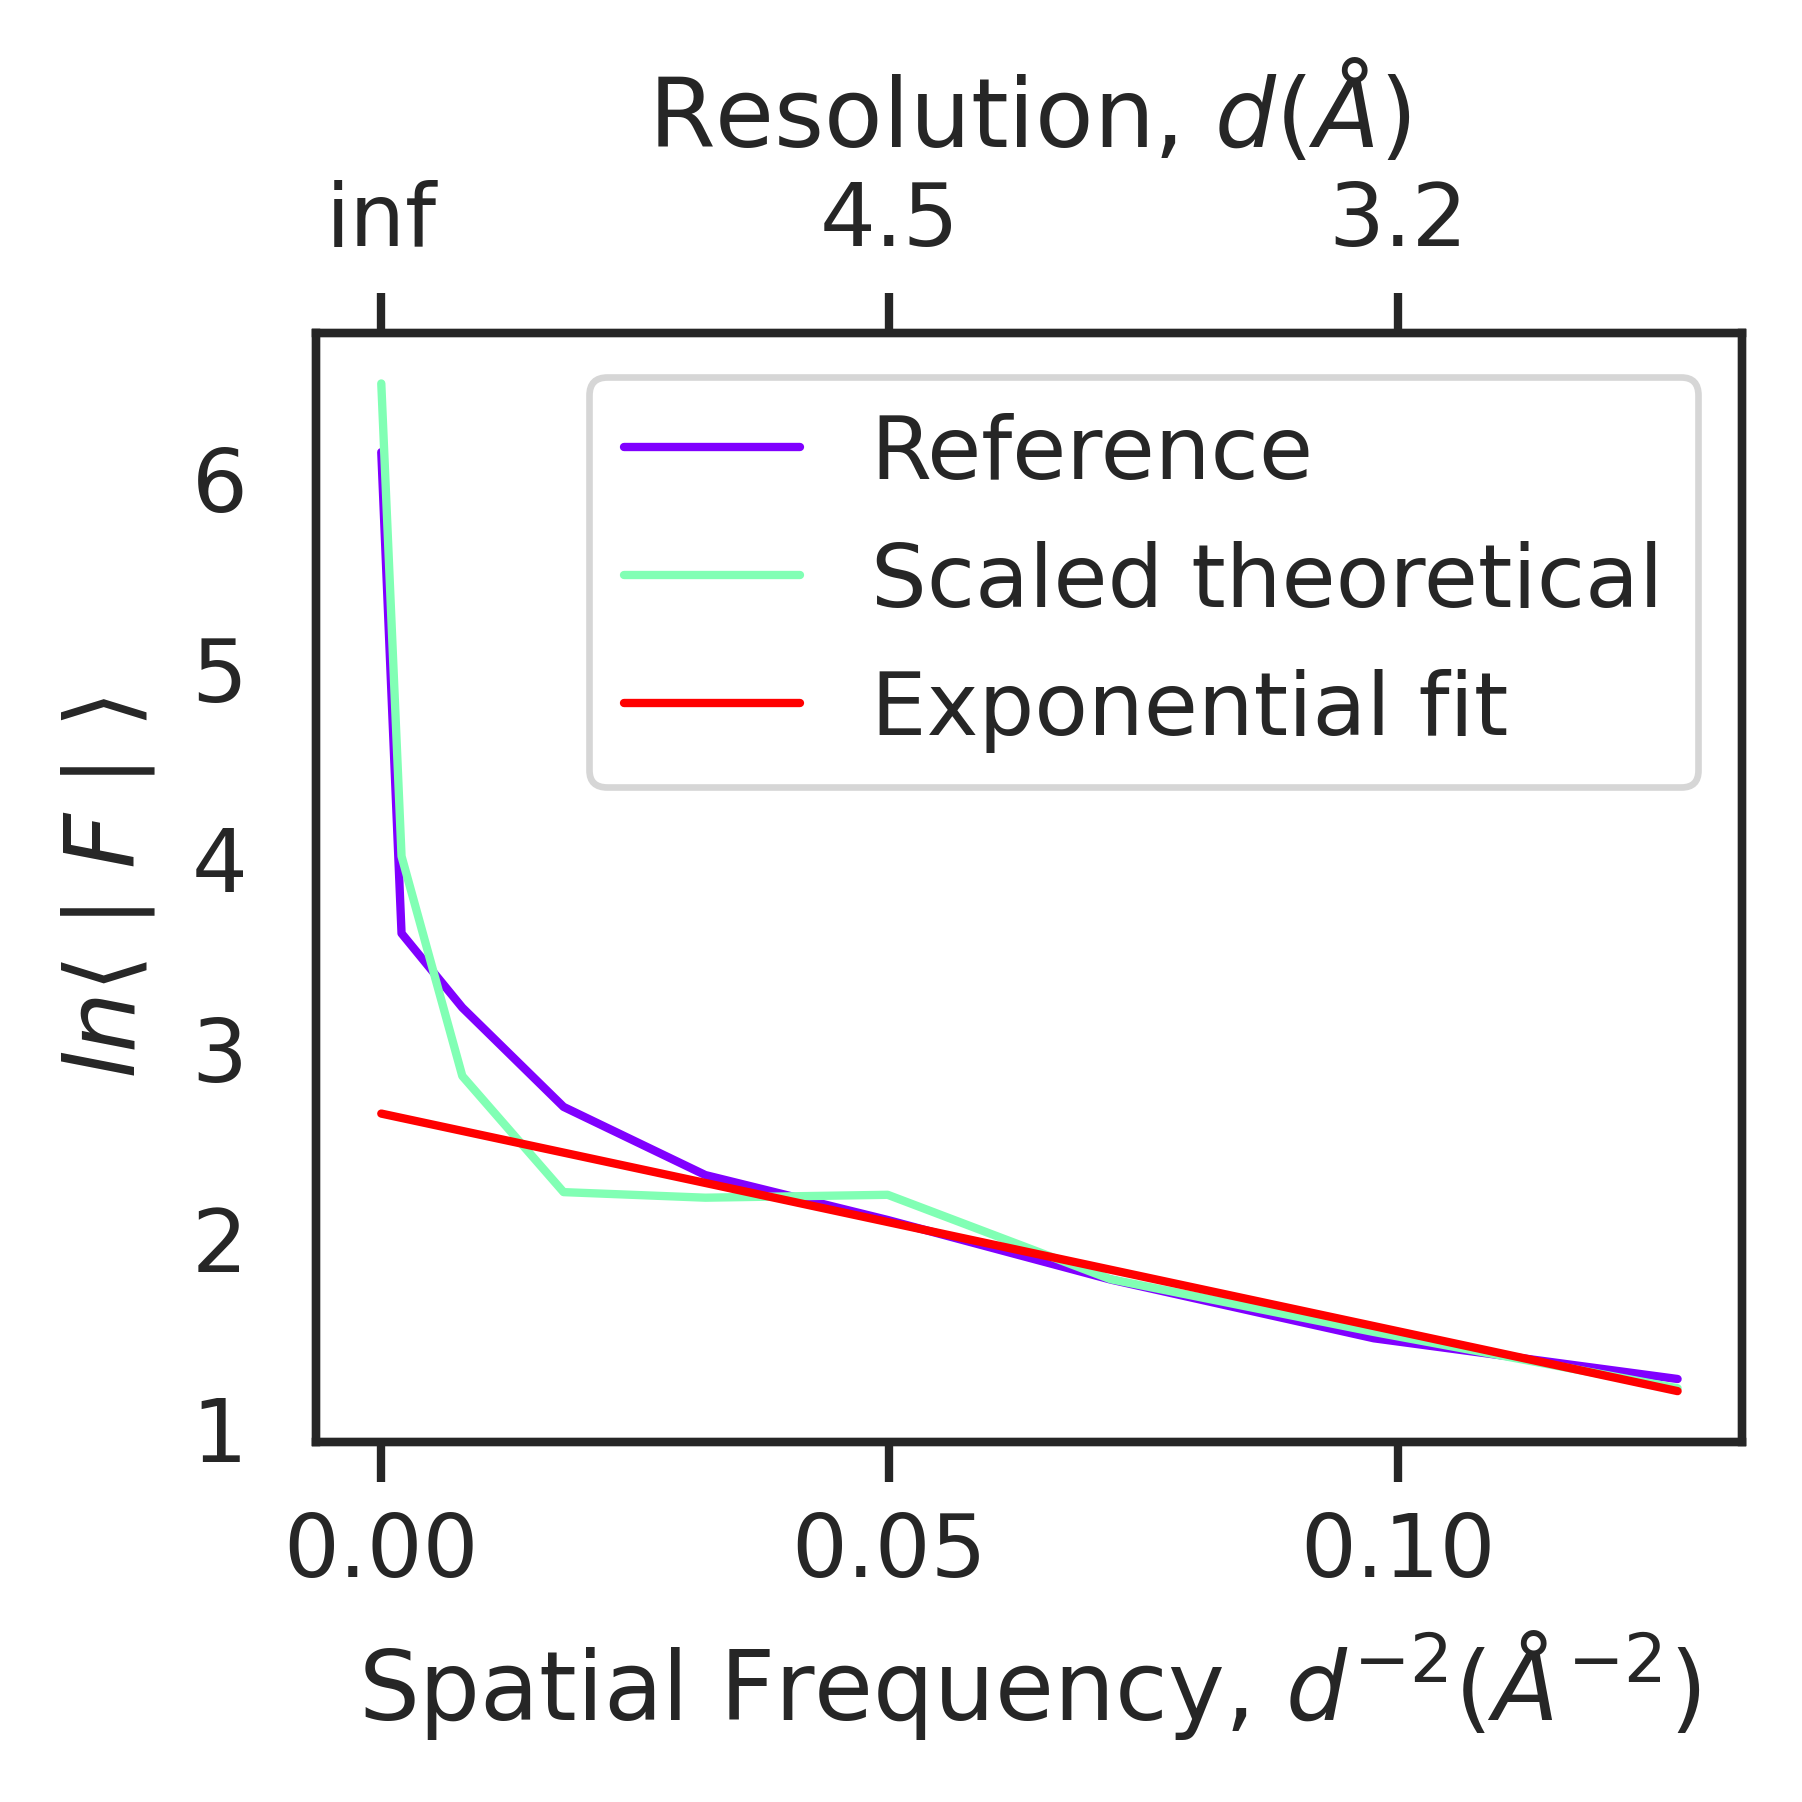

In [213]:
# plot the scaled_theoretical_tuple and the reference_profile_tuple
fig_scaled = pretty_plot_radial_profile(common_freq, [rp_pseudo, scaled_theoretical_tuple[1], exp_fit], figsize_cm=(8,8),
                                legends=["Reference", "Scaled theoretical", "Exponential fit"],showlegend=True,
                                plot_type="make_log", fontscale=1.2, linewidth=1, font="Arial")


In [218]:
# Shade the area between wilson_cutoff_local and fsc_cutoff with a different color
axes = fig_scaled.axes[0]
axes.axvspan(1/fsc_cutoff**2, 1/wilson_cutoff_local**2, alpha=0.05, color='red')
fig_scaled.savefig("/home/abharadwaj1/papers/elife_paper/figure_information/outputs/figure_2/emd_3061_scaled_theoretical_profile.eps", bbox_inches='tight')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [215]:
1/wilson_cutoff_local

0.1470644530568748

In [216]:
fig_reference = pretty_plot_radial_profile